### **Step 1 - Imports and Genereal Settings**

---



In [20]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

### **Step 2 - Exploring Categorical and Numerical Data**

---



In [35]:
# Read and assign data

df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/passengerSatisfaction.csv'
    )

In [22]:
# Display data

df.sample(n=5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
83265,83265,107888,Female,Loyal Customer,22,Business travel,Business,2429,2,2,2,2,5,5,5,5,3,2,5,3,5,5,0,0.0,satisfied
33230,33230,87492,Female,Loyal Customer,39,Business travel,Business,1718,3,3,3,3,5,5,5,5,5,5,5,5,5,5,0,0.0,satisfied
21404,21404,28284,Male,disloyal Customer,35,Business travel,Business,867,1,1,1,5,1,1,2,1,4,5,4,5,5,1,0,0.0,neutral or dissatisfied
11720,11720,27723,Female,disloyal Customer,24,Business travel,Eco,1252,2,2,2,2,1,2,1,1,1,4,4,3,5,1,0,0.0,neutral or dissatisfied
56240,56240,108824,Male,Loyal Customer,26,Business travel,Business,2595,3,3,3,3,4,4,4,4,5,4,5,3,5,4,5,0.0,satisfied


In [23]:
# Shape of data

print(f"Dataset has {df.shape[0]} rows, and {df.shape[1]} columns.")

Dataset has 103904 rows, and 25 columns.


In [36]:
# As a first step, let's standardize column names.

def standardize_column_names(df):

    """
    Standardizes column names of a pandas dataframe.
    
    Args:
        df (pandas.DataFrame): The dataframe to standardize its column names.

    Returns:
        None.
    """

    df.columns = df.columns.str.strip()  # Remove leading and trailing spaces
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    df.columns = df.columns.str.replace('[^\w\s]', '_', regex=True)  # Remove special characters
    df.columns = df.columns.str.lower()  # Lowercase all characters

    print("Column names have been standardized!")

# Standardize
standardize_column_names(df)

Column names have been standardized!


In [37]:
# Some of the columns are unnecessary. Let's drop them.

def drop_columns(column_list, df):
  
    """
    Drops columns from a pandas dataframe that match the names in a given list.
    
    Args:
        column_list (list of str): A list of column names to drop from the dataframe
        df (pandas.DataFrame): The dataframe from which to drop columns
        
    Returns:
        None.
    """

    not_found = [col for col in column_list if col not in df.columns]
    if not_found:
        print(f"The following columns were not found in the dataframe:\n{not_found}")

    found = [col for col in df.columns if col in column_list]
    if found:
        df = df.drop(columns=found, inplace=True)
        print(f"The following columns have been dropped:\n{found}")

# Columns to drop
column_list = ["unnamed__0", "id"]

# Drop
drop_columns(column_list, df)

The following columns have been dropped:
['unnamed__0', 'id']


In [38]:
# Let's identify categorical and numerical columns.

def categorize_columns(df):

    """
    This function takes a pandas DataFrame as input and returns a DataFrame categorized by data type.

    Args:
        df (pd.DataFrame): The pandas DataFrame to categorize.

    Returns:
        pd.DataFrame: A new DataFrame with three columns: 'categoricals', 'numericals', and 'datetimes'
    """
    
    # Categorize columns
    cat_cols = list(df.select_dtypes(include=['category', 'object']).columns)
    num_cols = list(df.select_dtypes(include=['float64', 'int64']).columns)
    datetime_cols = list(df.select_dtypes(include=['datetime']).columns)

    # Create empty cells
    max_len = max(len(cat_cols), len(num_cols), len(datetime_cols))
    cat_cols += [''] * (max_len - len(cat_cols))
    num_cols += [''] * (max_len - len(num_cols))
    datetime_cols += [''] * (max_len - len(datetime_cols))

    # Create new dataframe
    df_categories = pd.DataFrame(
        {'categoricals': cat_cols,
         'numericals': num_cols,
         'datetimes': datetime_cols}
         )

    # Center the text and column names
    centered_text = {'text-align': 'center'}
    centered_header = {'selector': 'th', 'props': [('text-align', 'center')]}
    df_categories = df_categories.style.set_properties(**centered_text).set_table_styles([centered_header])

    return df_categories

# Categorize columns
categorize_columns(df)

,categoricals,numericals,datetimes
0,gender,age,
1,customer_type,flight_distance,
2,type_of_travel,inflight_wifi_service,
3,class,departure_arrival_time_convenient,
4,satisfaction,ease_of_online_booking,
5,,gate_location,
6,,food_and_drink,
7,,online_boarding,
8,,seat_comfort,
9,,inflight_entertainment,


In [39]:
# Even though some of the numerical columns' data type is integer or float, they
# are actually categorical data.

# Let's convert them.

# Indexes to convert
convert_indexes = [0, 1, 3, 4] + list(range(6, 20))

# Convert
df.iloc[:,convert_indexes] = df.iloc[:,convert_indexes].astype('category')

# Check data types
categorize_columns(df)

,categoricals,numericals,datetimes
0,gender,age,
1,customer_type,flight_distance,
2,type_of_travel,departure_delay_in_minutes,
3,class,arrival_delay_in_minutes,
4,inflight_wifi_service,,
5,departure_arrival_time_convenient,,
6,ease_of_online_booking,,
7,gate_location,,
8,food_and_drink,,
9,online_boarding,,


In [40]:
# Now, we can check for duplicated rows.

def handle_duplicates(df):

    '''
    Finds duplicated rows in a Pandas DataFrame, displays them to the user,
    and optionally drops them.

    Args:
        df (pd.DataFrame): The pandas DataFrame to drop from.

    Returns:
        None.
    '''
    
    # Find duplicated rows
    duplicates = df[df.duplicated(keep=False)]

    # If no duplicated rows, print a message
    if len(duplicates) == 0:
        print("There are no duplicated rows in the dataset.")
        user_input = ""
    # If there duplicate rows, display them
    else:
        print(f"There are {len(duplicates)} duplicated rows in the dataset:\n")
        print(duplicates)
        # Ask the user if they want to drop the duplicates
        user_input = input("Do you want to drop the duplicated rows? (y/n) ")
    
    if user_input.lower() == "y":
        df.drop_duplicates(inplace=True)
        print(f"{len(duplicates)} rows have been dropped!")
    else:
        print("No rows have been dropped!")

# Check duplicates
handle_duplicates(df)

There are no duplicated rows in the dataset.
No rows have been dropped!


In [41]:
# Unique values

index = 1
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Print number of unique elements of categorical columns
for col in df.columns:
    if col in cat_cols:
        print(f"{index}. '{col}' has {df[col].nunique()} unique values.")
    index += 1

1. 'gender' has 2 unique values.
2. 'customer_type' has 2 unique values.
4. 'type_of_travel' has 2 unique values.
5. 'class' has 3 unique values.
7. 'inflight_wifi_service' has 6 unique values.
8. 'departure_arrival_time_convenient' has 6 unique values.
9. 'ease_of_online_booking' has 6 unique values.
10. 'gate_location' has 6 unique values.
11. 'food_and_drink' has 6 unique values.
12. 'online_boarding' has 6 unique values.
13. 'seat_comfort' has 6 unique values.
14. 'inflight_entertainment' has 6 unique values.
15. 'on_board_service' has 6 unique values.
16. 'leg_room_service' has 6 unique values.
17. 'baggage_handling' has 5 unique values.
18. 'checkin_service' has 6 unique values.
19. 'inflight_service' has 6 unique values.
20. 'cleanliness' has 6 unique values.
23. 'satisfaction' has 2 unique values.


Not imbalanced data:
         the minority class represents 43.33% of the total instances, more than 15%.



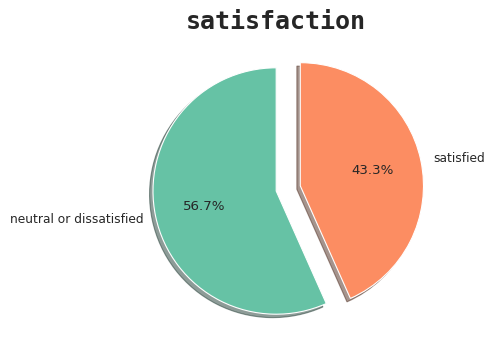

In [42]:
# Check if the data is balanced or not.

def check_imbalance(df, column_name, target_colors=['#8b324d','#387149']):

    """
    Checks if the target variable in a Pandas DataFrame is imbalanced.

    Args:
        target_name (str): The name of the target variable to check.
        df (pandas.DataFrame): The DataFrame containing the target variable.

    Returns:
        None.
    """
    sns.set_context("paper")
    # Count the number of instances of each class
    target_counts = df[column_name].value_counts()

    # Calculate the proportion of the minority class
    minority_proportion = target_counts.min() / target_counts.sum()

    # Check if the minority class represents less than 15% of the total instances
    if minority_proportion < 0.15:
        print(f"Imbalanced data:\n\
         the minority class represents {round(minority_proportion*100, 2)}% of the total instances, less than 15%.\n")
    else:
        print(f"Not imbalanced data:\n\
         the minority class represents {round(minority_proportion*100, 2)}% of the total instances, more than 15%.\n")

    # Plot a pie chart of the target variable
    explode = (0,0.2)

    plt.figure(figsize=(4,4))

    plt.pie(target_counts, explode=explode, labels=target_counts.index,
            autopct='%1.1f%%', shadow=True, startangle=90,
            )

    plt.title(column_name, fontsize=18,
              weight='bold', fontname = 'monospace')
    
    plt.show()

# Check imbalance
check_imbalance(df, column_name='satisfaction')

Not imbalanced data:
         the minority class represents 49.25% of the total instances, more than 15%.



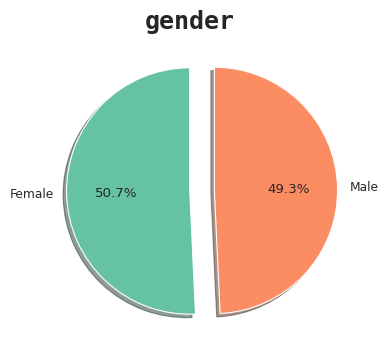

In [43]:
# Now, let's check imbalance for gender class.

check_imbalance(df, column_name='gender')

Not imbalanced data:
         the minority class represents 31.04% of the total instances, more than 15%.



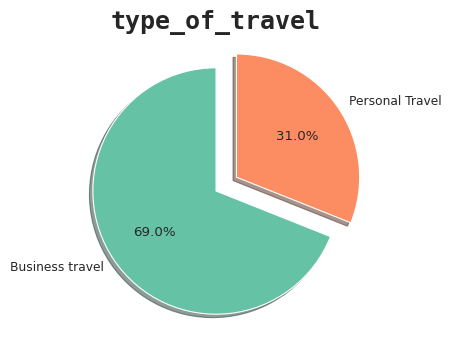

In [44]:
# The last column we would like to check for imbalance is travel type.

check_imbalance(df, column_name='type_of_travel')

### **Step 3 - Visualization**

---



In [45]:
# Let's visualize categorical data.
# First let's create a simple function.

def plot_counts(df, x, hue):

    '''
    Plots a countplot for categorical data using seaborn's 'countplot'.

    Args:
        df (pandas.DataFrame): The DataFrame to pull columns from.
        x (str): String of the column name for x-axis.
        hue (str): String for hue parameter of countplot.

    Returns:
        None
    '''

    # Plot size
    plt.subplots(figsize=(7, 5))

    # Countplot
    ax = sns.countplot(x=x, hue=hue, palette='Set2', data=df)

    # Write the count numbers on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

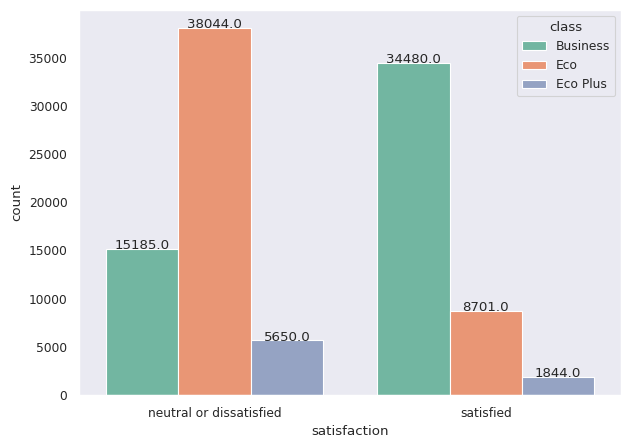

In [46]:
# Class - Satisfaction

plot_counts(df, 'satisfaction', 'class')

# Most of the passengers who flew in economy plus or economy class were dissatisfied with the flight.

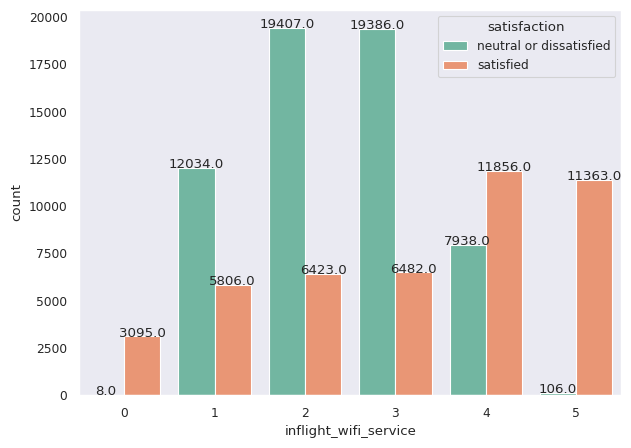

In [47]:
# Wi-fi Service - Satisfaction

plot_counts(df, 'inflight_wifi_service', 'satisfaction')

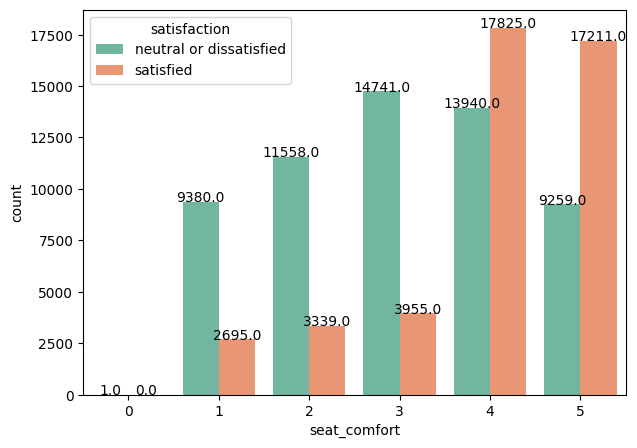

In [ ]:
# Seat Comfort - Satisfaction

plot_counts(df, 'seat_comfort', 'satisfaction')

# Most passengers who rated the comfort of the seats higher were satisfied with the flight.

In [ ]:
# Now let's visualize numerical data.
# First let's create a simple function.

def plot_box_hist(df, x, y):

    '''
    Plots a boxplot for numerical data using seaborn's 'boxplot' and 'histplot'.

    Args:
        df (pandas.DataFrame): The DataFrame to pull columns from.
        x (str): String of the column name for x-axis and hue.
        y (str): String of the column name for y-axis.

    Returns:
        None
    '''

    # Plot size
    fig, ax = plt.subplots(1, 2, figsize = (15,5))

    # Boxplot
    sns.boxplot(x=x, y=y, palette="Set2", data=df, ax=ax[0])

    # Histplot
    sns.histplot(df, x=y, hue=x, multiple="stack", palette="Set2",
                 edgecolor=".3", linewidth=.5, ax=ax[1])

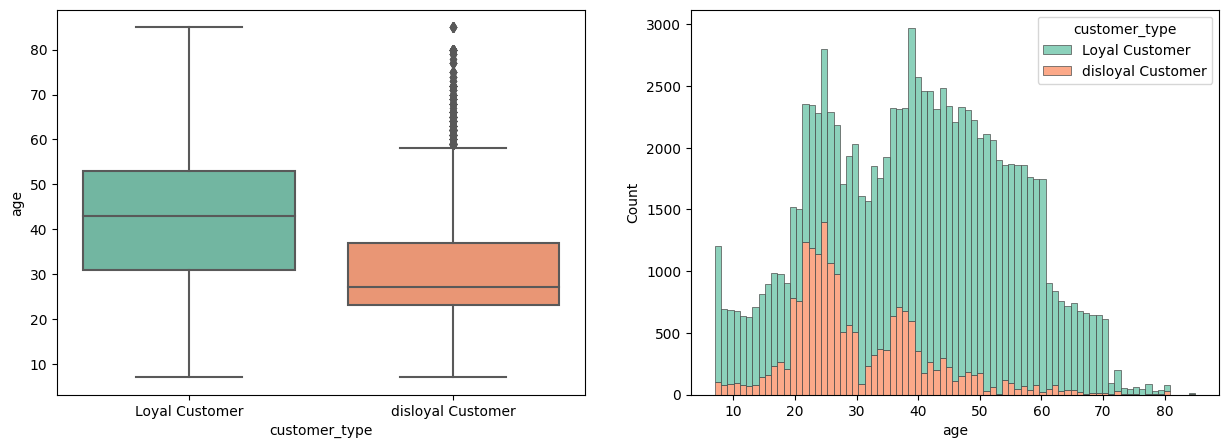

In [ ]:
# Customer Type - Age

plot_box_hist(df, "customer_type", "age")

# Regular customers are between the ages of 30 and 50.

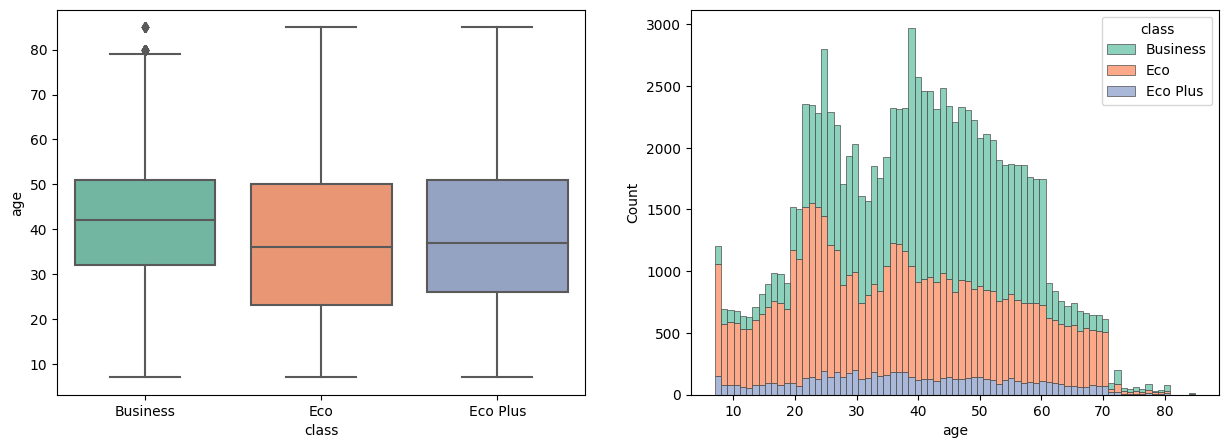

In [ ]:
# Class - Age

plot_box_hist(df, "class", "age")

# Regular customers mainly buy business class for themselves.

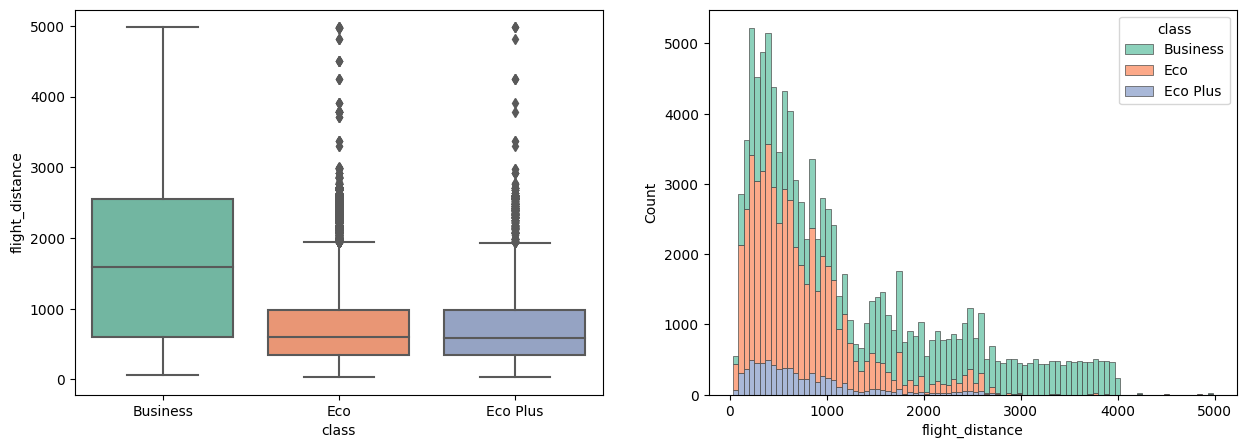

In [ ]:
# Class - Flight Distance

plot_box_hist(df, "class", "flight_distance")

# Customers mostly fly in business class for longer distances.

### **Step 4 - Handling Null/Mising Values, Outliers**

---



In [48]:
# Let's see which columns have missing values first.

def find_missing_values(df):

    """
    Finds categorical and numerical columns with missing values in a Pandas dataframe.

    Args:
        df (pandas.DataFrame): Input dataframe to check for missing values.
        
    Returns:
        None.
    """

    # Get list of categorical and numerical columns
    cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)
    num_cols = list(df.select_dtypes(include=['int', 'float']).columns)

    # Check for missing values in categorical columns
    cat_missing = [
        (col, round(df[col].isnull().mean() * 100, 2))
         for col in cat_cols if df[col].isnull().any()
         ]

    # Report missing values
    if cat_missing:
        print(f"There are {len(cat_missing)} categorical column with missing values:")
        for col, percentage in cat_missing:
            print(f"{col} - {percentage}%")
    else:
        print("No missing values found in categorical columns.\n")

    # Check for missing values in numerical columns
    num_missing = [
        (col, round(df[col].isnull().mean() * 100, 2))
         for col in num_cols if df[col].isnull().any()
         ]

    # Report missing values     
    if num_missing:
        print(f"There are {len(num_missing)} numerical column with missing values:")
        for col, percentage in num_missing:
            print(f"{col} - {df[col].isnull().sum()} rows missing - {percentage}%")
    else:
        print("No missing values found in numerical columns")

# Find missing values
find_missing_values(df)

# Fill missing values with median
df['arrival_delay_in_minutes'].fillna(
    df['arrival_delay_in_minutes'].median(axis=0),
     inplace=True
     )
print("\nMissing values have been replaced with the median.")

No missing values found in categorical columns.

There are 1 numerical column with missing values:
arrival_delay_in_minutes - 310 rows missing - 0.3%

Missing values have been replaced with the median.


In [ ]:
# Let's for this example filter out outliers.

def filter_outliers(df, column_name):
    
    """
    Detects outlier values in a given column of a Pandas DataFrame and filters them out.

    Args:
        df (pandas.DataFrame): The DataFrame containing the column to detect outliers for.
        column_name (str): The name of the column to detect outliers for.
        

    Returns
        None.
    """

    #print(f"Dataset has {df.shape[0]} rows, and {df.shape[1]} columns.")

    
    # Calculate percentiles
    percentiles = np.percentile(df[column_name], [25, 75])
    
    # Calculate interquartile range (IQR)
    iqr = percentiles[1] - percentiles[0]
    
    # Calculate cutoff for outliers
    cutoff = 1.5 * iqr
    lower_bound = percentiles[0] - cutoff
    upper_bound = percentiles[1] + cutoff
    
    # Identify outlier values
    outliers = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
    
    # Filter out outliers from the dataset
    df = df[~outliers]

    print(f"After filtering out '{column_name}' column, dataset has now {df.shape[0]} rows, and {df.shape[1]} columns.")

# Filter out outliers in ages
filter_outliers(df, "age")

# Filter out outliers in ages
filter_outliers(df, "flight_distance")

# Filter out outliers in ages
filter_outliers(df, "departure_delay_in_minutes")

# Filter out outliers in ages
filter_outliers(df, "arrival_delay_in_minutes")

After filtering out 'age' column, dataset has now 103904 rows, and 23 columns.
After filtering out 'flight_distance' column, dataset has now 101613 rows, and 23 columns.
After filtering out 'departure_delay_in_minutes' column, dataset has now 89375 rows, and 23 columns.
After filtering out 'arrival_delay_in_minutes' column, dataset has now 89950 rows, and 23 columns.


### **Step 5 - Feature Engineering and Data Preperation for Modeling**

---



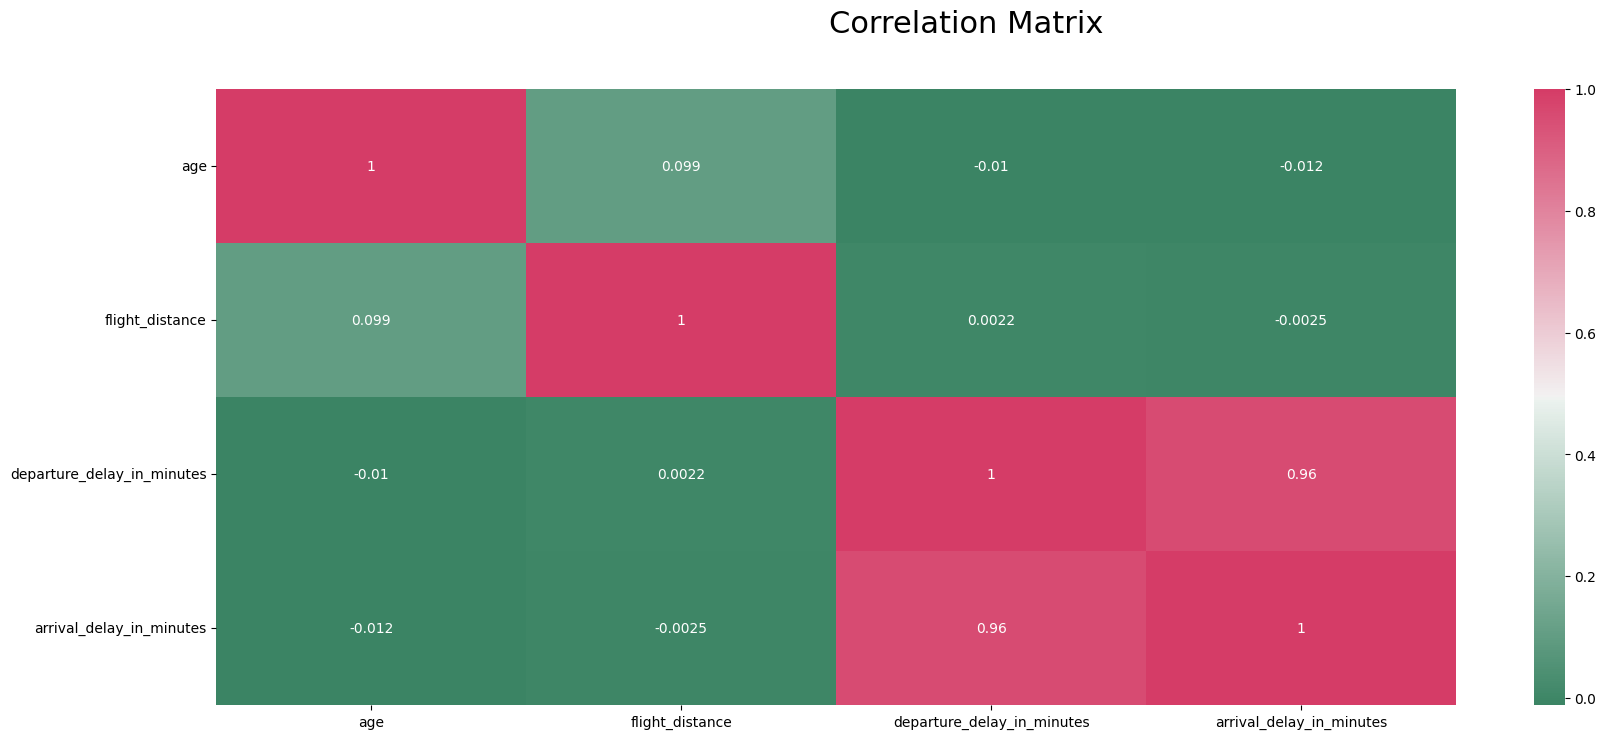

In [ ]:
# Correlation Analysis

# Create a figure and a set of subplots
fig = plt.subplots(figsize=(20,8))

# Set a centered title
plt.suptitle('Correlation Matrix', fontsize=22)

# Heatmap
cmap = sns.diverging_palette(150, 1, as_cmap=True)
sns.heatmap(df.corr(),annot=True,cmap=cmap)

plt.show()

# From correlation matrix, we see that departure delays and arrival delays have
# very high correlation which is expected.
# So we should drop one of them.

In [49]:
# We will drop departure delays  with the function we used above.

# Columns to drop
column_list = ["unnamed__0", "id", "departure_delay_in_minutes"]

# Drop
drop_columns(column_list, df)

The following columns were not found in the dataframe:
['unnamed__0', 'id']
The following columns have been dropped:
['departure_delay_in_minutes']


In [50]:
# Now, we encode categorical columns.

def encode_cat_cols(df):
    
    """
    Encodes all categorical columns in a Pandas DataFrame using Scikit-learn's LabelEncoder class.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        None.
    """

    # Instantiate label encoder
    le = LabelEncoder()

    # Find categorical columns
    cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

    # Encode each categorical column
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    print("Categorical columns have been encoded.")

# Encode categorical columns
encode_cat_cols(df)

Categorical columns have been encoded.


In [ ]:
# At this stage we can split the data.

# Create features and target
X = df.drop('satisfaction', axis=1)
Y = df['satisfaction']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify=Y,
                                                    test_size=0.1,
                                                    random_state=42)

print("Shape of training set:", x_train.shape)
print("Shape of test set:", x_test.shape)

Shape of training set: (93513, 21)
Shape of test set: (10391, 21)


In [ ]:
# Next, we will scale the data with sklearn's StandardScaler class.

# Instantiate scaler
ss = StandardScaler()

# Scale features
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [ ]:
x_train


array([[ 1.01409741,  2.10952856, -0.22613517, ..., -1.39535088,
        -1.74514944,  0.07232187],
       [-0.98609856, -0.47403957,  0.43551006, ...,  1.15552878,
         0.54252294, -0.39209254],
       [ 1.01409741, -0.47403957,  0.83249719, ...,  0.30523556,
         0.54252294,  0.35613067],
       ...,
       [ 1.01409741, -0.47403957,  0.96482624, ...,  1.15552878,
        -0.22003452, -0.39209254],
       [ 1.01409741,  2.10952856, -0.42462874, ..., -0.54505766,
        -1.74514944,  0.38193147],
       [ 1.01409741, -0.47403957,  0.89866172, ...,  1.15552878,
         1.3050804 ,  0.45933387]])

### **Step 6 - Modeling**

---



In [ ]:
# KNN

knn = KNeighborsClassifier()

knn.set_params(n_neighbors = 10)
knn.fit(x_train, y_train)

err_train = np.mean(y_train != knn.predict(x_train))
err_test  = np.mean(y_test != knn.predict(x_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.06309283201266135
Error on the test sample:  0.07448753729188722


In [ ]:
# SVC

svc = SVC(gamma='auto')
svc.fit(x_train, y_train)

err_train = np.mean(y_train != svc.predict(x_train))
err_test  = np.mean(y_test != svc.predict(x_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.04089271010447745
Error on the test sample:  0.042825522086420945


In [ ]:
# Random Forest

rf = ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

err_train = np.mean(y_train != rf.predict(x_train))
err_test  = np.mean(y_test != rf.predict(x_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.0
Error on the test sample:  0.03637763449138678


In [ ]:
# Extremely Randomized Trees

ert = ensemble.ExtraTreesClassifier(n_estimators=100).fit(x_train, y_train)

err_train = np.mean(y_train != ert.predict(x_train))
err_test  = np.mean(y_test != ert.predict(x_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.0
Error on the test sample:  0.03974593398133


In [ ]:
# AdaBoost

ada = ensemble.AdaBoostClassifier(n_estimators=100)
ada.fit(x_train, y_train)

err_train = np.mean(y_train != ada.predict(x_train))
err_test = np.mean(y_test != ada.predict(x_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.0704821789483815
Error on the test sample:  0.07160042344336445


In [ ]:
# GBT

gbt = ensemble.GradientBoostingClassifier(n_estimators=100)
gbt.fit(x_train, y_train)

err_train = np.mean(y_train != gbt.predict(x_train))
err_test = np.mean(y_test != gbt.predict(x_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.057606963737662144
Error on the test sample:  0.05668366855933019


### **The classifiers Random and Extremely Random Forest showed the best result**

---

